In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy.fft as fft
from scipy import signal as scisig
from viterbi_utils import *
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)

In [2]:
df_train = pd.read_pickle('../features/train_clean.pkl')
df_test = pd.read_pickle('../features/test_clean.pkl')
TARGET = "open_channels"
df_test[TARGET] = 0

print(f"train size:{df_train.shape}, test size:{df_test.shape}")
df_train.head()

train size:(4500000, 6), test size:(2000000, 7)


,time,signal,open_channels,local_time,batch,mini_batch
0,0.0001,-2.7600,0,0.0001,1,1
1,0.0002,-2.8557,0,0.0002,1,1
2,0.0003,-2.4074,0,0.0003,1,1
3,0.0004,-3.1404,0,0.0004,1,1
4,0.0005,-3.1525,0,0.0005,1,1


In [3]:
BATCH_GROUP = [6]
df_train = df_train[df_train.batch.isin(BATCH_GROUP)].reset_index(drop=True)

In [4]:
# remove pink noise
import numpy.fft as fft
from scipy import signal as scisig

def bandstop(x, samplerate = 1000000, fp = np.array([4925, 5075]), fs = np.array([4800, 5200])):
    fn = samplerate / 2   # Nyquist frequency
    wp = fp / fn
    ws = fs / fn
    gpass = 1
    gstop = 10.0

    N, Wn = scisig.buttord(wp, ws, gpass, gstop)
    b, a = scisig.butter(N, Wn, "bandstop")
    y = scisig.filtfilt(b, a, x)
    return y

def bandpass(x, samplerate = 1000000, fp = np.array([4925, 5075]), fs = np.array([4800, 5200])):
    fn = samplerate / 2   # Nyquist frequency
    wp = fp / fn
    ws = fs / fn
    gpass = 1
    gstop = 10.0

    N, Wn = scisig.buttord(wp, ws, gpass, gstop)
    b, a = scisig.butter(N, Wn, "bandpass")
    y = scisig.filtfilt(b, a, x)
    return y

def Arrange_mean(signal, channels, sig_mean, channel_range):
    signal_out = signal.copy()
    for i in range(channel_range):
        signal_out[channels == i] -= sig_mean[i]
    return signal_out

def Recover_mean(signal, channels, sig_mean, channel_range):
    signal_out = signal.copy()
    for i in range(channel_range):
        signal_out[channels == i] += sig_mean[i]
    return signal_out

In [5]:
# feature engineering here
def fe(df, is_train):

    df["group"] = df["batch"].astype("str") + "_" + df["mini_batch"].astype("str")

    return df


df_train = fe(df_train, is_train=1)
df_train = fe(df_train, is_train=0)

In [6]:
use_cols = [
    col for col in df_train.columns if col not in
    ["time", "local_time", "open_channels", "batch", "mini_batch", "group"]
]
print("Used columns is", use_cols)

Used columns is ['signal']


In [7]:
batch = df_train[df_train.batch.isin(BATCH_GROUP) & (df_train.mini_batch==1)]

def get_mean(batch, col=TARGET):

    sig_mean = []
    for chan_i in range(batch[col].nunique()):
        sig_mean.append(batch[batch[col] == chan_i].signal.mean())

    return sig_mean
sig_mean = get_mean(batch)
print(sig_mean)
signal = batch.signal.values
channel = batch.open_channels.values
# sig_mean = [-2.749, -1.517, -0.282, 0.952, 2.19, 3.429]
sig_noise = Arrange_mean(signal, channel, sig_mean, 6)

sig_filter = bandstop(sig_noise)
sig_noise_pink = bandpass(sig_noise)

sig_recover = Recover_mean(sig_filter, channel, sig_mean, 6)

[-2.7282226, -1.4891213, -0.26735625, 0.9667369, 2.2038143, 3.4331856]


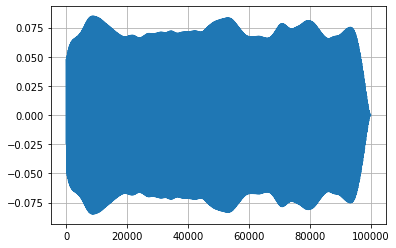

In [8]:
plt.plot(sig_noise_pink[:500000])
plt.grid()

In [9]:
# from scipy.signal import find_peaks
# peaks, _ = find_peaks(sig_noise_pink)
# peaks[0]

In [10]:
f = 50 / 10000
t = np.array([i for i in range(len(sig_noise_pink))])

In [11]:
# original
signal_manual_filter = signal
state = batch[TARGET].values
viterbi = PosteriorDecoder().fit(signal_manual_filter, state)
_, oof = viterbi.predict(signal_manual_filter)

print("F1 macro =", f1_score(y_pred=oof, y_true=state, average='macro').round(6))

F1 macro = 0.970012


In [12]:
# recover
signal_manual_filter = sig_recover
state = batch[TARGET].values
viterbi = PosteriorDecoder().fit(signal_manual_filter, state)
_, oof = viterbi.predict(signal_manual_filter)

print("F1 macro =", f1_score(y_pred=oof, y_true=state, average='macro').round(6))

F1 macro = 0.972098


In [13]:
# b = 1.1
# manual_noise = np.sin(2 * np.pi * f * t + b) * 0.06
# signal_manual_filter = signal - manual_noise
# state = batch[TARGET].values
# viterbi = PosteriorDecoder().fit(signal_manual_filter, state)
# _, oof = viterbi.predict(signal_manual_filter)

# print(b, "F1 macro =", f1_score(y_pred=oof, y_true=state, average='macro').round(6))
# # 0.973

In [31]:
for i in range(0,32):
    
    b = 0.1 * i
    manual_noise = np.sin(2 * np.pi * f * t + b) * 0.04
    signal_manual_filter = signal - manual_noise
    state = batch[TARGET].values
    viterbi = PosteriorDecoder().fit(signal_manual_filter, state)
    _, oof = viterbi.predict(signal_manual_filter)

    print(np.round(b, 2), "F1 macro =", f1_score(y_pred=oof, y_true=state, average='macro').round(6))

0.0 F1 macro = 0.968999
0.1 F1 macro = 0.969009
0.2 F1 macro = 0.968945
0.3 F1 macro = 0.968764
0.4 F1 macro = 0.968844
0.5 F1 macro = 0.968379
0.6 F1 macro = 0.96833
0.7 F1 macro = 0.968933
0.8 F1 macro = 0.969005
0.9 F1 macro = 0.968588
1.0 F1 macro = 0.968679
1.1 F1 macro = 0.96896
1.2 F1 macro = 0.968535
1.3 F1 macro = 0.968552
1.4 F1 macro = 0.96855
1.5 F1 macro = 0.968621
1.6 F1 macro = 0.968654
1.7 F1 macro = 0.96871
1.8 F1 macro = 0.968672
1.9 F1 macro = 0.968831
2.0 F1 macro = 0.969295
2.1 F1 macro = 0.969818
2.2 F1 macro = 0.969732
2.3 F1 macro = 0.969758
2.4 F1 macro = 0.97031
2.5 F1 macro = 0.970345
2.6 F1 macro = 0.970287
2.7 F1 macro = 0.969957
2.8 F1 macro = 0.969892
2.9 F1 macro = 0.969915
3.0 F1 macro = 0.969908
3.1 F1 macro = 0.970094


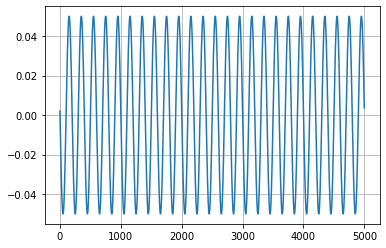

In [15]:
plt.plot(manual_noise[:5000])
plt.grid()

In [16]:
# df_train.loc[df_train.batch.isin(BATCH_GROUP), "signal"] = sig_recover

# viterbi_cols = ["viterbi_" + str(i) for i in range(6)]
# for col in viterbi_cols:
#     df_train[col] = 0
#     df_train[col] = 0

# signal = df_train["signal"].values
# state = df_train[TARGET].values
# viterbi = PosteriorDecoder().fit(signal, state)

# kf = GroupKFold(n_splits=5)
# for index, (tr_idx, val_idx) in enumerate(kf.split(df_train[use_cols], df_train[TARGET], df_train["group"])):
#     print("Running folder", index , ": Evaluate on", np.unique(df_train["group"][val_idx]))

#     signal_valid = df_train.loc[val_idx]["signal"].values
#     df_train.loc[val_idx, viterbi_cols], df_train.loc[val_idx, "oof"] = viterbi.predict(signal_valid)
#     print("F1 macro =", f1_score(y_pred=df_train.loc[val_idx, "oof"], y_true=df_train.loc[val_idx, TARGET], average='macro').round(4))

# use_cols = viterbi_cols + use_cols
# # original: 0.9703
# print("oof F1 score is:", f1_score(df_train["oof"].values, df_train[TARGET].values,
#          average='macro').round(4))